# Đề thi Cuối kỳ Hệ khuyến nghị 2025 (đề thi mẫu).

## Khoa học dữ liệu IUH. Thời gian làm bài: 90 phút.

**Bài 1.** (3 điểm) Đánh giá việc phân tích ma trận.

Cho một bảng *utility matrix* giữa 4 user và 4 item, trong đó có một số missing rating:

|Rating     | $I_1$    | $I_2$  | $I_3$   |  $I_4$  |
|----------|----------|--------|---------|---------|
| $U_1$    | 5     | 5     | 3    |   4 | 
| $U_2$ | 4    | 4      | 2     |   ?    |
| $U_3$  | 4     | ?      |   2  |    3 |
| $U_4$|   4  |   5    | ? |   2|

Bằng cách sử dụng kỹ thuật phân tích ma trận của lọc cộng tác, ta thu được hai ma trận sau như bên dưới:

$A=\left[ \begin{align}
  & \begin{matrix}
   1.2 & 1.8  \\
\end{matrix} \\ 
 & \begin{matrix}
   1.5 & 0.9  \\
\end{matrix} \\ 
 & \begin{matrix}
   1.5 & 1  \\
\end{matrix} \\ 
 & \begin{matrix}
   2 & 0.5  \\
\end{matrix} \\ 
\end{align} \right]$ và $\text{ }B=\left[ \begin{align}
  & \begin{matrix}
   1.5 & 2 & 0.8 & 0.7  \\
\end{matrix} \\ 
 & \begin{matrix}
   1.7 & 1.5 & 1.1 & 1.8  \\
\end{matrix} \\ 
\end{align} \right]$.

1. Hãy dự đoán giá trị cho các missing value.
2. Sử dụng thư viện scikit-learn để chạy lại lần nữa với số latent factor là $k=3$ và so sánh với kết quả trên (tham khảo lab 6).

In [1]:
import numpy as np

# Ma trận A (4 users x 2 latent factors)
A = np.array([
    [1.2, 1.8],
    [1.5, 0.9],
    [1.5, 1.0],
    [2.0, 0.5]
])

# Ma trận B (2 latent factors x 4 items)
B = np.array([
    [1.5, 2.0, 0.8, 0.7],
    [1.7, 1.5, 1.1, 1.8]
])

# Dự đoán ma trận rating bằng nhân A @ B
predicted_matrix = np.dot(A, B)

# In kết quả
print("🔹 Ma trận dự đoán (A·B):")
print(np.round(predicted_matrix, 2))


🔹 Ma trận dự đoán (A·B):
[[4.86 5.1  2.94 4.08]
 [3.78 4.35 2.19 2.67]
 [3.95 4.5  2.3  2.85]
 [3.85 4.75 2.15 2.3 ]]


In [2]:
from sklearn.decomposition import TruncatedSVD

# Ma trận gốc có missing values (NaN)
utility_matrix = np.array([
    [5, 5, 3, 4],
    [4, 4, 2, np.nan],
    [4, np.nan, 2, 3],
    [4, 5, np.nan, 2]
])

# Thay NaN bằng trung bình theo hàng (user)
filled_matrix = np.where(np.isnan(utility_matrix),
                         np.nanmean(utility_matrix, axis=1, keepdims=True),
                         utility_matrix)

# Truncated SVD với k = 3
svd = TruncatedSVD(n_components=3, random_state=42)
U = svd.fit_transform(filled_matrix)
VT = svd.components_

# Khôi phục ma trận
reconstructed_matrix = np.dot(U, VT)

# In kết quả
print("🔹 Ma trận dự đoán bằng SVD (k=3):")
print(np.round(reconstructed_matrix, 2))


🔹 Ma trận dự đoán bằng SVD (k=3):
[[5.06 5.03 2.93 3.94]
 [3.95 3.98 2.05 3.38]
 [3.99 2.99 2.02 3.01]
 [3.99 4.99 3.68 2.01]]


In [3]:
from sklearn.metrics import mean_squared_error

# Tính sai số giữa các phần không bị missing
mask = ~np.isnan(utility_matrix)
rmse = mean_squared_error(filled_matrix[mask], reconstructed_matrix[mask], squared=False)
print("🔸 RMSE giữa ma trận gốc (đã điền) và ma trận SVD:", round(rmse, 4))


🔸 RMSE giữa ma trận gốc (đã điền) và ma trận SVD: 0.037


c:\Users\thong\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Bài 2.** (2 điểm) Cho ma trận user-item như sau, trong đó ở ô màu vàng: là testing rating trong đó số bên phải là giá trị được dự đoán bởi mô hình, 
số bên trái là giá trị thực tế.

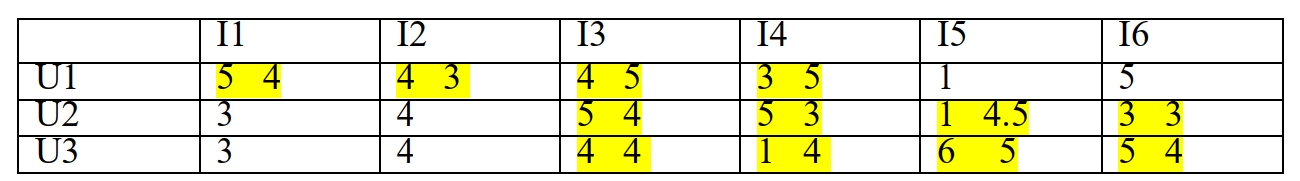

1. Hãy tính F-score của U1, U2, U3 và của cả hệ thống.
2. Hãy tính RMSE của cả hệ thống.

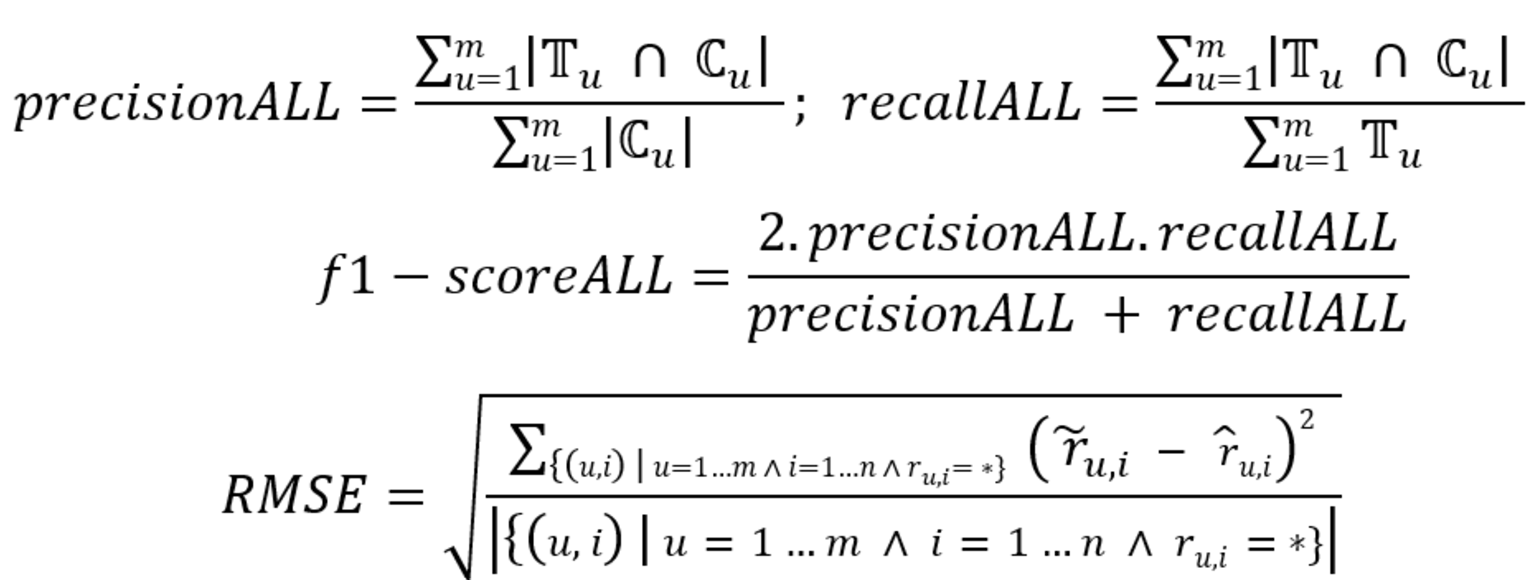

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# ==== B1. Dữ liệu test từ bảng ====
# Cấu trúc: test_data = {User: [(ground_truth, predicted), ...]}
test_data = {
    'U1': [(5, 4), (4, 3), (4, 5), (3, 5)],
    'U2': [(5, 4), (5, 3), (1, 4.5), (3, 3)],
    'U3': [(4, 4), (1, 4), (6, 5), (5, 4)]
}

# ==== B2. Các tham số ban đầu ====
threshold = 4  # ngưỡng để đánh giá "relevant"
gt_all = []    # Ground truth toàn hệ thống
pred_all = []  # Prediction toàn hệ thống

# Tổng tích lũy để tính Precision/Recall toàn hệ thống
TP_all = 0  # True positives
T_all = 0   # Tổng item thực sự relevant
P_all = 0   # Tổng item được dự đoán là relevant

# Kết quả từng user
results = []

# ==== B3. Tính toán cho từng user ====
for user, pairs in test_data.items():
    gt_user = [gt for gt, _ in pairs]
    pred_user = [pred for _, pred in pairs]

    # Cập nhật toàn hệ thống
    gt_all.extend(gt_user)
    pred_all.extend(pred_user)

    # Tập thực sự relevant (rating thực >= threshold)
    T_u = sum(1 for r in gt_user if r >= threshold)
    # Tập mô hình dự đoán là relevant (rating dự đoán >= threshold)
    C_u = sum(1 for r in pred_user if r >= threshold)
    # Giao giữa 2 tập
    TP_u = sum(1 for g, p in zip(gt_user, pred_user) if g >= threshold and p >= threshold)

    # Precision, Recall, F1 cho user
    precision_u = TP_u / C_u if C_u > 0 else 0
    recall_u = TP_u / T_u if T_u > 0 else 0
    f1_u = 2 * precision_u * recall_u / (precision_u + recall_u) if (precision_u + recall_u) > 0 else 0

    # Ghi nhận kết quả
    results.append((user, round(precision_u, 3), round(recall_u, 3), round(f1_u, 3)))

    # Cộng dồn hệ thống
    TP_all += TP_u
    P_all += C_u
    T_all += T_u

# ==== B4. Tính Precision, Recall, F1 cho toàn hệ thống ====
precision_all = TP_all / P_all if P_all > 0 else 0
recall_all = TP_all / T_all if T_all > 0 else 0
f1_all = 2 * precision_all * recall_all / (precision_all + recall_all) if (precision_all + recall_all) > 0 else 0

results.append(("ALL", round(precision_all, 3), round(recall_all, 3), round(f1_all, 3)))

# ==== B5. Tính RMSE toàn hệ thống ====
rmse = mean_squared_error(gt_all, pred_all, squared=False)

# ==== B6. Hiển thị kết quả ====
df = pd.DataFrame(results, columns=["User", "Precision", "Recall", "F1-Score"])
print("🎯 Bảng Precision / Recall / F1-Score:")
print(df.to_string(index=False))
print(f"\n📉 RMSE toàn hệ thống: {round(rmse, 3)}")


🎯 Bảng Precision / Recall / F1-Score:
User  Precision  Recall  F1-Score
  U1      0.667   0.667     0.667
  U2      0.500   0.500     0.500
  U3      0.750   1.000     0.857
 ALL      0.667   0.750     0.706

📉 RMSE toàn hệ thống: 1.714


c:\Users\thong\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# ==== Dữ liệu test: (ground_truth, predicted)
test_data = {
    'U1': [(5, 4), (4, 3), (4, 5), (3, 5)],
    'U2': [(5, 4), (5, 3),(1, 4.5), (3, 3)],
    'U3': [(4, 4), (1, 4), (6, 5), (5, 4)]
}

# ==== Tham số ====
threshold = 4  # Ngưỡng đánh giá "thích"
gt_all = []    # Ground truth toàn hệ thống
pred_all = []  # Predict toàn hệ thống

TP_all = 0     # Tổng true positive (dự đoán đúng là thích)
P_all = 0      # Tổng predicted positive (dự đoán là thích)
T_all = 0      # Tổng actual positive (thực tế là thích)

results = []

# ==== Tính F1-score từng user ====
for user, ratings in test_data.items():
    gt_user = [gt for gt, _ in ratings]
    pred_user = [pred for _, pred in ratings]

    gt_all.extend(gt_user)
    pred_all.extend(pred_user)

    T_u = sum(1 for r in gt_user if r >= threshold)
    C_u = sum(1 for r in pred_user if r >= threshold)
    TP_u = sum(1 for g, p in zip(gt_user, pred_user) if g >= threshold and p >= threshold)

    precision = TP_u / C_u if C_u > 0 else 0
    recall = TP_u / T_u if T_u > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    results.append((user, round(precision, 3), round(recall, 3), round(f1, 3)))

    TP_all += TP_u
    P_all += C_u
    T_all += T_u

# ==== F1-score toàn hệ thống ====
precision_all = TP_all / P_all if P_all > 0 else 0
recall_all = TP_all / T_all if T_all > 0 else 0
f1_all = 2 * precision_all * recall_all / (precision_all + recall_all) if (precision_all + recall_all) > 0 else 0

results.append(("ALL", round(precision_all, 3), round(recall_all, 3), round(f1_all, 3)))

# ==== RMSE toàn hệ thống ====
rmse = mean_squared_error(gt_all, pred_all, squared=False)

# ==== Kết quả ====
df_result = pd.DataFrame(results, columns=["User", "Precision", "Recall", "F1-Score"])
print("🎯 F-score từng user và toàn hệ thống:")
print(df_result.to_string(index=False))
print(f"\n📉 RMSE toàn hệ thống: {round(rmse, 3)}")


🎯 F-score từng user và toàn hệ thống:
User  Precision  Recall  F1-Score
  U1      0.667   0.667     0.667
  U2      0.500   0.500     0.500
  U3      0.750   1.000     0.857
 ALL      0.667   0.750     0.706

📉 RMSE toàn hệ thống: 1.714


c:\Users\thong\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Bài 3.** (2.5 điểm) Cho sẵn hệ khuyến nghị bằng hình ảnh tương tự lab 7, có đưa sẵn code cài đặt (trong đề thi sẽ có cung cấp code phần này). Yêu cầu:
1) SV tự tổng hợp một số hình ảnh làm dữ liệu theo chủ đề tự chọn và chạy với code đề cho.
2) Tự demo với một số hình ảnh và đưa ra nhận xét chung về độ hiệu quả của mô hình. Thử đề xuất cách điều chỉnh cài đặt đã có để cải tiến hệ thống tốt hơn.

**Bài 4.** (2.5 điểm) Trong HAI chọn MỘT.

Tìm hiểu về cách cài đặt phương pháp lọc cộng tác trong hệ khuyến nghị bằng một trong hai kỹ thuật deep learning (SV tự tìm hiểu trước trên Internet), sử dụng bộ dữ liệu MovieLen kích thước vừa và nhỏ, train ít epoch:

1. autoencoder.
2. Restricted Boltzmann Machines.

### RBM

In [6]:
import pandas as pd
import numpy as np

df = pd.read_csv("https://files.grouplens.org/datasets/movielens/ml-100k/u.data",
                 sep="\t", names=["user_id", "item_id", "rating", "timestamp"])

n_users = df['user_id'].nunique()
n_items = df['item_id'].nunique()

user_item_matrix = df.pivot(index='user_id', columns='item_id', values='rating').fillna(0).astype(np.float32)


In [7]:
import torch
from torch import nn

class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super().__init__()
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))

    def sample_hidden(self, v):
        prob_h = torch.sigmoid(torch.matmul(v, self.W.t()) + self.h_bias)
        return prob_h, torch.bernoulli(prob_h)

    def sample_visible(self, h):
        prob_v = torch.sigmoid(torch.matmul(h, self.W) + self.v_bias)
        return prob_v, torch.bernoulli(prob_v)

    def forward(self, v0):
        ph0, h0 = self.sample_hidden(v0)
        pvk, vk = self.sample_visible(h0)
        phk, _ = self.sample_hidden(vk)
        return v0, vk, ph0, phk

# Chuẩn bị dữ liệu
train_tensor = torch.FloatTensor(user_item_matrix.values)
rbm = RBM(n_visible=n_items, n_hidden=64)

# Train 5 epoch nhanh
for epoch in range(5):
    for user in train_tensor:
        v0 = user.unsqueeze(0)
        v0, vk, ph0, phk = rbm(v0)
        rbm.W.data += 0.01 * (torch.matmul(ph0.t(), v0) - torch.matmul(phk.t(), vk))
        rbm.v_bias.data += 0.01 * (v0 - vk).sum(0)
        rbm.h_bias.data += 0.01 * (ph0 - phk).sum(0)
        
        
    print(f"Epoch {epoch+1} Loss: {torch.mean((v0 - vk) ** 2).item():.4f}")

Epoch 1 Loss: 1.1326
Epoch 2 Loss: 1.1534
Epoch 3 Loss: 1.1581
Epoch 4 Loss: 1.1344
Epoch 5 Loss: 1.1017


In [8]:
user_ids = [0, 1]  # Người dùng 1 và 2 (index từ 0)

with torch.no_grad():
    for uid in user_ids:
        v = train_tensor[uid].unsqueeze(0)
        prob_h, _ = rbm.sample_hidden(v)
        v_reconstructed, _ = rbm.sample_visible(prob_h)
        prediction = v_reconstructed.squeeze().numpy()
        actual = v.squeeze().numpy()

        unrated_items = np.where(actual == 0)[0]
        top_predicted_idx = unrated_items[np.argsort(prediction[unrated_items])[::-1][:5]]
        top_predicted_scores = prediction[top_predicted_idx]

        print(f"\n🎯 Gợi ý top phim cho user_id = {uid+1}")
        for idx, score in zip(top_predicted_idx, top_predicted_scores):
            print(f"  🎬 Movie ID: {idx+1:3d} | Dự đoán rating: {score:.3f}")



🎯 Gợi ý top phim cho user_id = 1
  🎬 Movie ID: 318 | Dự đoán rating: 1.000
  🎬 Movie ID: 328 | Dự đoán rating: 1.000
  🎬 Movie ID: 313 | Dự đoán rating: 1.000
  🎬 Movie ID: 300 | Dự đoán rating: 1.000
  🎬 Movie ID: 302 | Dự đoán rating: 1.000

🎯 Gợi ý top phim cho user_id = 2
  🎬 Movie ID:  22 | Dự đoán rating: 1.000
  🎬 Movie ID:  15 | Dự đoán rating: 1.000
  🎬 Movie ID:  12 | Dự đoán rating: 1.000
  🎬 Movie ID:  28 | Dự đoán rating: 1.000
  🎬 Movie ID:  96 | Dự đoán rating: 1.000


### ENCODER

In [9]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Tải dữ liệu MovieLens 100k từ URL gốc
df = pd.read_csv("https://files.grouplens.org/datasets/movielens/ml-100k/u.data", sep="\t",
                 names=["user_id", "item_id", "rating", "timestamp"])

# Pivot: mỗi user là 1 hàng, mỗi item là 1 cột
user_item_matrix = df.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
user_item_np = user_item_matrix.values
n_users, n_items = user_item_np.shape


In [10]:
class UserRatingDataset(Dataset):
    def __init__(self, ratings):
        self.ratings = torch.FloatTensor(ratings)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.ratings[idx]

# Mô hình autoencoder đơn giản
class AutoEncoder(nn.Module):
    def __init__(self, n_items):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_items, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, n_items),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [11]:
# Tách tập train/test đơn giản: giữ lại 10% rating thật
train_data = user_item_np.copy()
mask = np.random.rand(*train_data.shape) < 0.1
test_data = train_data * mask
train_data = train_data * ~mask

# Dataset và DataLoader
train_dataset = UserRatingDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Khởi tạo mô hình
model = AutoEncoder(n_items)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Train
model.train()
for epoch in range(10):  # ít epoch như đề yêu cầu
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        pred = model(batch)
        loss = loss_fn(pred, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")


Epoch 1 - Loss: 40.4318
Epoch 2 - Loss: 36.2813
Epoch 3 - Loss: 35.0565
Epoch 4 - Loss: 34.2197
Epoch 5 - Loss: 33.6308
Epoch 6 - Loss: 33.1541
Epoch 7 - Loss: 32.8236
Epoch 8 - Loss: 32.5155
Epoch 9 - Loss: 32.2166
Epoch 10 - Loss: 31.9573


In [12]:
model.eval()
with torch.no_grad():
    inputs = torch.FloatTensor(test_data)
    outputs = model(inputs)

# Chỉ tính RMSE tại các ô thật sự được giữ lại
mask_tensor = torch.FloatTensor(mask)
rmse = torch.sqrt(((outputs - inputs) ** 2 * mask_tensor).sum() / mask_tensor.sum())
print(f"\n📉 RMSE trên test set: {rmse:.4f}")



📉 RMSE trên test set: 0.8268


In [13]:
# ==== Gợi ý top-5 item cho một số user ====
user_ids = [0, 1]  # User ID trong Python (user_id=1,2 trong MovieLens)

print("\n🔎 Dự đoán top-5 phim cho một số người dùng:")
for uid in user_ids:
    user_input = torch.FloatTensor(user_item_np[uid]).unsqueeze(0)  # (1, n_items)
    with torch.no_grad():
        output = model(user_input).squeeze().numpy()
    
    actual_rated = user_item_np[uid]
    unrated_indices = np.where(actual_rated == 0)[0]
    
    # Lấy 5 item có rating dự đoán cao nhất trong số chưa đánh giá
    top_predicted_idx = unrated_indices[np.argsort(output[unrated_indices])[::-1][:5]]
    top_predicted_scores = output[top_predicted_idx]

    print(f"\n👤 User ID = {uid+1}")
    for i, score in zip(top_predicted_idx, top_predicted_scores):
        print(f"   🎬 Movie ID = {i+1:3d} | Dự đoán rating: {score:.4f}")



🔎 Dự đoán top-5 phim cho một số người dùng:

👤 User ID = 1
   🎬 Movie ID = 318 | Dự đoán rating: 1.0000
   🎬 Movie ID = 276 | Dự đoán rating: 1.0000
   🎬 Movie ID = 475 | Dự đoán rating: 1.0000
   🎬 Movie ID = 357 | Dự đoán rating: 1.0000
   🎬 Movie ID = 405 | Dự đoán rating: 1.0000

👤 User ID = 2
   🎬 Movie ID =   9 | Dự đoán rating: 1.0000
   🎬 Movie ID =  15 | Dự đoán rating: 1.0000
   🎬 Movie ID = 508 | Dự đoán rating: 0.9999
   🎬 Movie ID = 124 | Dự đoán rating: 0.9998
   🎬 Movie ID = 744 | Dự đoán rating: 0.9998
